In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="darkgray">Classical Reservoir Computing:</font><br>Workshop Version

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create and use a classical reservoir computing model in <strong>Python</strong>.<br>
            Compare this classical reservoir with the equivalent quantum reservoir.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included)</td></tr>
    <tr><td><strong>Timeframe:</strong></td>
        <td>01/07/25-26/09/25 (possible extensions)</td></tr>
    <tr><td><strong>References:</strong></td>
        <td><ul>
            <li><a href = "https://doi.org/10.1103/PhysRevApplied.14.024065" target="_blank">
                Chen, J., Nurdin, H.I., Yamamoto, N., 2020. Temporal Information Processing on Noisy Quantum Computers. Phys. Rev. Applied 14, 024065.
</a></li>
            <li><a href = "https://doi.org/10.1088/2634-4386/ac7db7" target="_blank">Cucchi, M., Abreu, S., Ciccone, G., Brunner, D., Kleemann, H., 2022. Hands-on reservoir computing: a tutorial for practical implementation. Neuromorph. Comput. Eng. 2, 032002. 
</a></li>
            <li><a href = "https://doi.org/10.1038/s41467-021-25801-2" target="_blank">Gauthier, D.J., Bollt, E., Griffith, A., Barbosa, W.A.S., 2021. Next generation reservoir computing. Nat Commun 12, 5564.
</a></li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="./LICENSE" target="_blank">GNU General Public License V3</a></td></tr>
</table>

### Reservoir computing (RC)
RC is a concept derived from recurrent neural networks (RNN). 
It can be applied to all types of data, however, it is especially useful for temporal data. 
Reservoir computing utilises a large sparse neural network of randomly initialised and fixed weights (_**reservoir**_),
responsible for transforming input into a higher-dimensional space.
In high-dimensional space, data can be easily separated  (_**classified**_) by using a simple linear model (_**readout layer**_),
such a ridge regression.
The _**reservoir dynamics**_ can be specified by a set of differential equations (_**update rules**_)
responsible for describing changes to the reservoir state over time.

Typical reservoir computing applications include: time-series forecasting, speech recognition and video analysis, control of robots or autonomous vehicles, as well as, predicting weather patterns and stock markets.

## <font color="blue">Data preparation</font>

<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### Prepare synthetic time series data

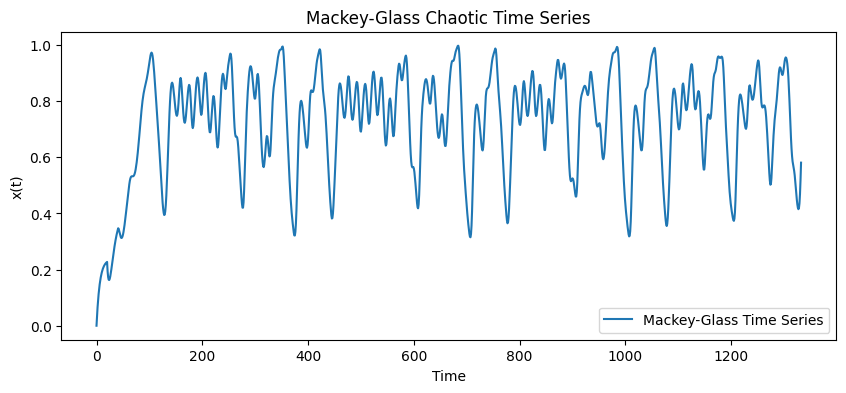

In [15]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    x_min, x_max = np.min(x), np.max(x)
    x = (x - x_min) / (x_max - x_min)

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
# time_series = mackey_glass(dt=1, T=2000)
time_series = mackey_glass(beta=0.17, dt=1.5, T=2000, tau=30)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

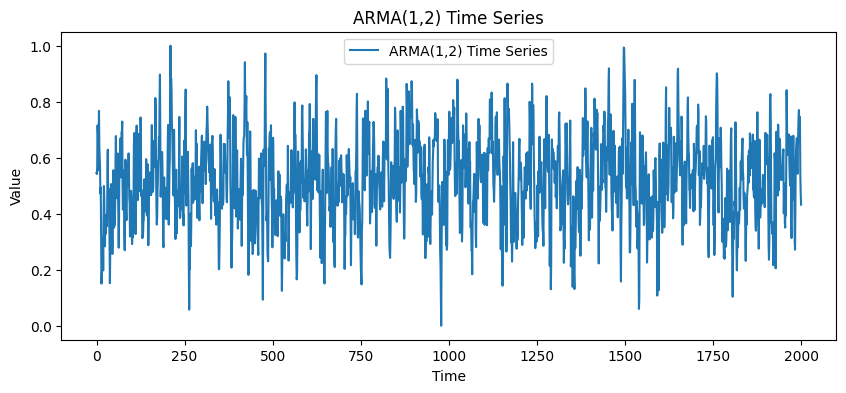

In [27]:
# ======== 1. Generate data from ARMA(1,2) ============
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
np.random.seed(42)

N = 2000 # Length of the series
ar_params = np.array([1, -0.7])     # AR(1): x_t = 0.7*x_{t-1}
ma_params = np.array([1, 0.5, -0.3]) # MA(2): + 0.5*e_{t-1} - 0.3*e_{t-2}
noise = np.random.normal(0, 1, N)

# Generate ARMA data
time_series = lfilter(ma_params, ar_params, noise)

# Scale the data to the range [0, 1] to match the notebook's encoding requirements
time_series = (time_series - np.min(time_series)) / (np.max(time_series) - np.min(time_series))

# Plot the new time series
plt.figure(figsize=(10, 4))
plt.plot(time_series, label='ARMA(1,2) Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARMA(1,2) Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions

In [28]:
### Prepare the data
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 10  # Use the last 10 time steps to predict the next step
train_size = 1000  # Use the first 1000 points for training
test_size = 500   # Use the next 500 points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

print(f"Training data shape: {train_inputs.shape}, {train_outputs.shape}")
print(f"Testing data shape: {test_inputs.shape}, {test_outputs.shape}")

Training data shape: (990, 10), (990,)
Testing data shape: (490, 10), (490,)


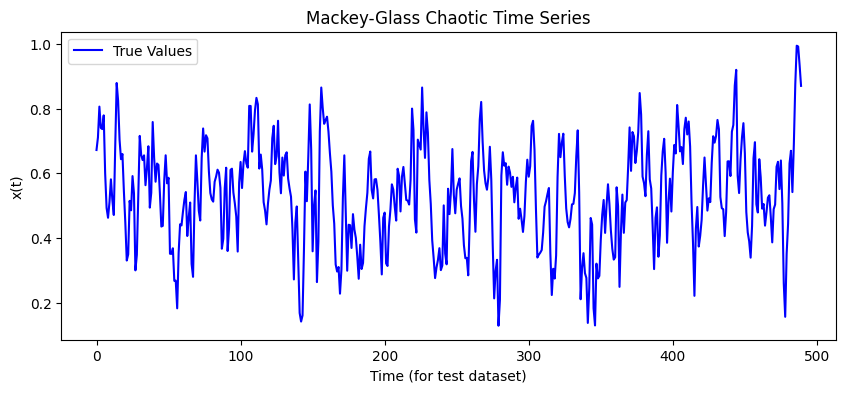

In [29]:
### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## <font color="blue">Model development</font>

### Reservoir hyper-parameters

In [30]:
reservoir_size = 100
input_dim = window_size
seed = 2025

### Initialize the reservoir

In [31]:
def initialize_reservoir(reservoir_size, input_dim, spectral_radius=0.9, sparsity=0.1, leakage_rate=0.3):
    
    # Define random input weights (fixed, small and random)
    W_in = np.random.uniform(-0.1, 0.1, (reservoir_size, input_dim))

    # Set reservoir weights (large, sparse, fixed and random)
    # However, eliminate (1-sparsity) weights to make it more sparse
    W_res = np.random.randn(reservoir_size, reservoir_size)
    W_res[np.random.rand(*W_res.shape) > sparsity] = 0

    # Scale the matrix by its spectral radius
    eigenvalues = np.linalg.eigvals(W_res)
    current_spectral_radius = np.max(np.abs(eigenvalues))
    W_res = (spectral_radius / current_spectral_radius) * W_res

    return W_in, W_res, leakage_rate

### Train the reservoir
*Includes the readout layer.*

In [32]:
# Update the reservoir state
def update_reservoir_state(input_seq, W_in, W_res, reservoir_state, leakage_rate):
    new_state = (1 - leakage_rate) * reservoir_state + \
                leakage_rate * np.tanh(W_in @ input_seq + W_res @ reservoir_state)
    return new_state

# Train the reservoir and compute the readout weights
def train_reservoir(train_inputs, train_outputs, W_in, W_res, leakage_rate):
    reservoir_states = []
    reservoir_state = np.zeros(reservoir_size)

    for input_seq in train_inputs:
        reservoir_state = update_reservoir_state(input_seq, W_in, W_res, reservoir_state, leakage_rate)
        reservoir_states.append(reservoir_state)

    # Stack reservoir states and outputs
    R = np.vstack(reservoir_states)
    Y = train_outputs.reshape(-1, 1)

    # Train readout weights using ridge regression
    lambda_reg = 1e-6  # Regularization parameter
    W_out = Y.T @ R @ np.linalg.inv(R.T @ R + lambda_reg * np.eye(reservoir_size))

    return W_out

### Predict the output from inputs

In [33]:
def predict(test_inputs, W_in, W_res, W_out, leakage_rate):
    predictions = []
    reservoir_state = np.zeros(reservoir_size)

    for input_seq in test_inputs:
        reservoir_state = update_reservoir_state(input_seq, W_in, W_res, reservoir_state, leakage_rate)
        y_pred = W_out @ reservoir_state
        predictions.append(y_pred[0])

    return np.array(predictions)

### Testing


Reservoir weights shape: (100, 100)
Input weights shape: (100, 10)
Readout weights shape: (1, 100)



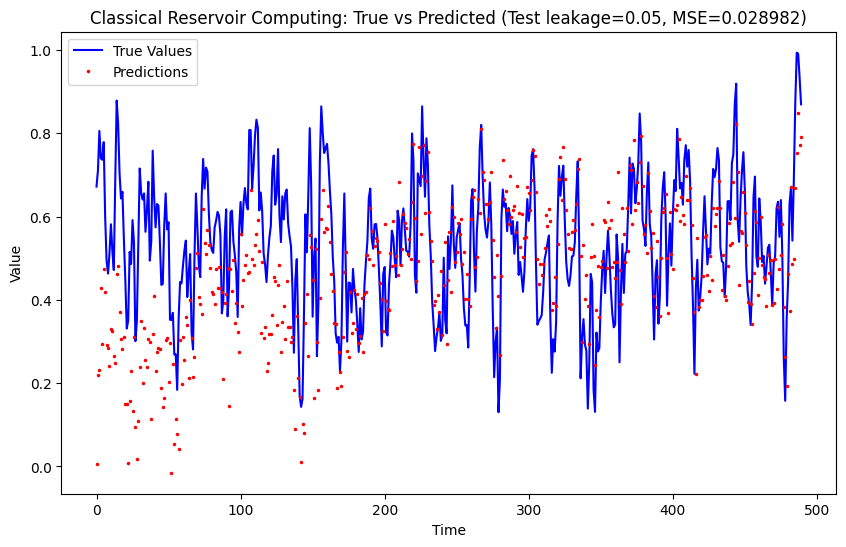

In [34]:
# For reproducibility
np.random.seed(seed)
test_leakage = 0.05

# Initialise the reservoir
W_in, W_res, _ = initialize_reservoir(reservoir_size, input_dim, leakage_rate=test_leakage)
print(f"\nReservoir weights shape: {W_res.shape}")
print(f"Input weights shape: {W_in.shape}")

# Train the reservoir
W_out = train_reservoir(train_inputs, train_outputs, W_in, W_res, test_leakage)
print(f"Readout weights shape: {W_out.shape}\n")

# Test reservoir
test_preds = predict(test_inputs, W_in, W_res, W_out, test_leakage)

# Evaluate performance
mse = np.mean((test_outputs - test_preds)**2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label="Predictions", color="red", linestyle="", marker='.', markersize=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f'Classical Reservoir Computing: True vs Predicted (Test leakage={test_leakage}, MSE={mse:0.6f})')
plt.legend()
plt.show()

### Experimenting with leakage

In [35]:
# Train with different leakage rates to find the optimum
leakage_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09]+\
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]+\
                [0.91, 0.93, 0.95, 0.97, 0.99]+\
                [0.993, 0.995, 0.997, 0.999]
leakage_rates = sorted(leakage_rates)

mse_scores = []
best_mse = float(np.inf)
best_params = None

for rate in leakage_rates:
    # For reproducibility
    # and consistency with above test
    np.random.seed(seed)
    
    W_out = train_reservoir(train_inputs, train_outputs, W_in, W_res, rate)
    test_preds = predict(test_inputs, W_in, W_res, W_out, rate)
    current_mse = np.mean((test_outputs - test_preds)**2)
    current_params = (rate, current_mse)
    mse_scores.append(current_params)
    print(f'Tested leakage rate: {rate:0.3f}, mse: {current_mse:0.6f}')
    
    if current_mse < best_mse:
        best_mse = current_mse
        best_params = current_params

Tested leakage rate: 0.010, mse: 0.124906
Tested leakage rate: 0.020, mse: 0.080496
Tested leakage rate: 0.030, mse: 0.080231
Tested leakage rate: 0.040, mse: 0.037513
Tested leakage rate: 0.050, mse: 0.028982
Tested leakage rate: 0.070, mse: 0.043817
Tested leakage rate: 0.080, mse: 0.054251
Tested leakage rate: 0.090, mse: 0.047030
Tested leakage rate: 0.100, mse: 0.039508
Tested leakage rate: 0.200, mse: 0.022643
Tested leakage rate: 0.300, mse: 0.010276
Tested leakage rate: 0.400, mse: 0.015448
Tested leakage rate: 0.500, mse: 0.009480
Tested leakage rate: 0.600, mse: 0.013844
Tested leakage rate: 0.700, mse: 0.015625
Tested leakage rate: 0.800, mse: 0.014548
Tested leakage rate: 0.900, mse: 0.012597
Tested leakage rate: 0.910, mse: 0.011979
Tested leakage rate: 0.930, mse: 0.010877
Tested leakage rate: 0.950, mse: 0.010119
Tested leakage rate: 0.970, mse: 0.009707
Tested leakage rate: 0.990, mse: 0.009610
Tested leakage rate: 0.993, mse: 0.009623
Tested leakage rate: 0.995, mse: 0

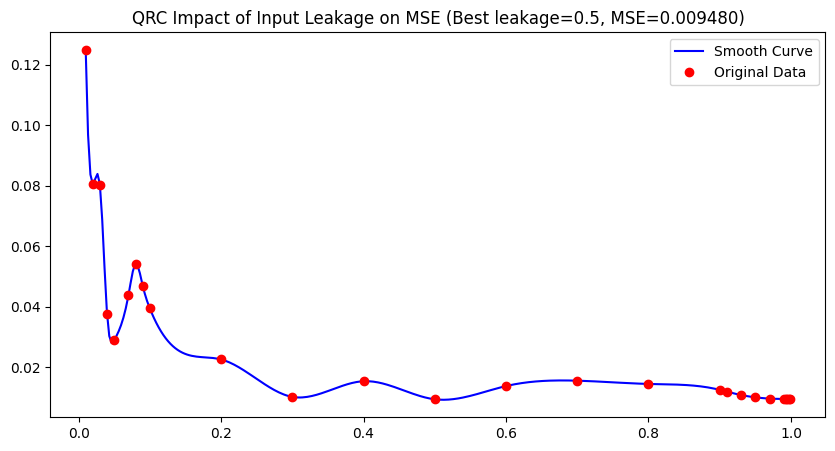

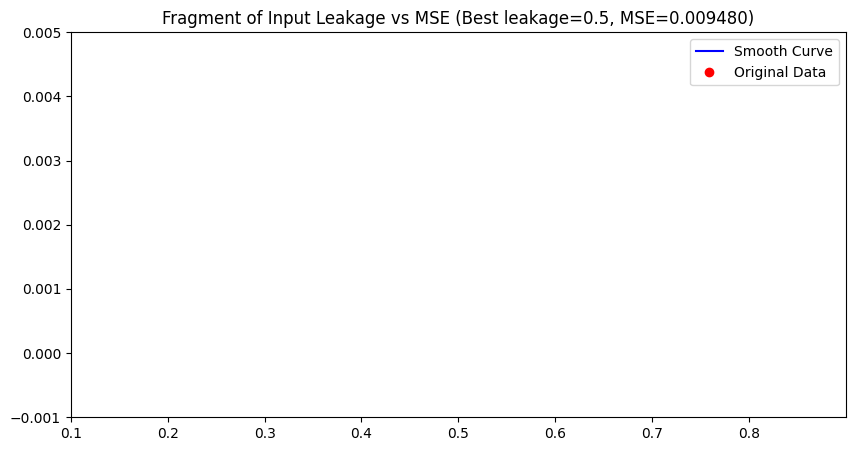

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Example data
X = np.array(leakage_rates)
y = np.array([mse for (rate, mse) in mse_scores])
best_rate, best_mse = best_params

# Generate smooth curve using spline interpolation
X_smooth = np.linspace(X.min(), X.max(), 300)  # 300 points for smoothness
spline = make_interp_spline(X, y, k=3)  # Cubic spline (k=3)
y_smooth = spline(X_smooth)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'QRC Impact of Input Leakage on MSE (Best leakage={best_rate}, MSE={best_mse:0.6f})')
plt.legend()
plt.show()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_smooth, y_smooth, '-', color="blue", label="Smooth Curve")  # Smoothed line
plt.plot(X, y, 'o', color="red", label="Original Data")  # Original points
plt.title(f'Fragment of Input Leakage vs MSE (Best leakage={best_rate}, MSE={best_mse:0.6f})')
plt.legend()
plt.ylim(-0.001, 0.005)
plt.xlim(0.1, 0.9)
start, end = plt.xlim()
plt.xticks(np.arange(start, end, 0.1))
plt.show()

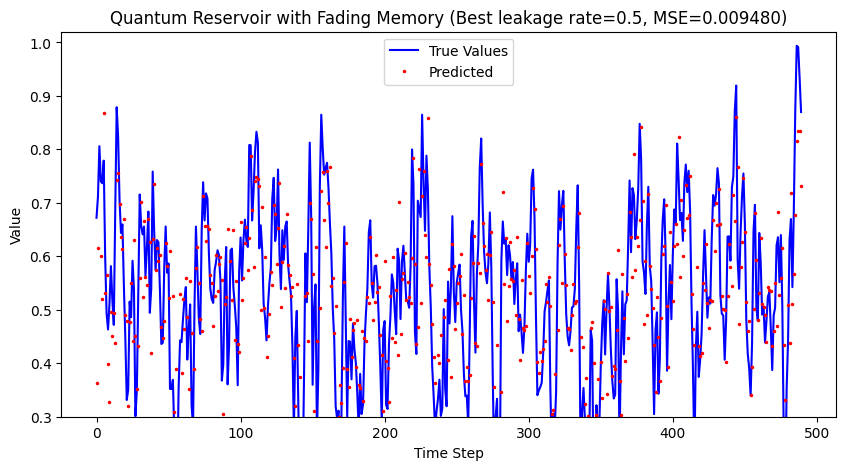

In [37]:
# Use best parameters for final prediction
best_rate, best_mse = best_params
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label=f"Predicted", color="red", linestyle="", marker='.', markersize=3)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.ylim(0.3, 1.02)
plt.title(f'Quantum Reservoir with Fading Memory (Best leakage rate={best_rate}, MSE={best_mse:0.6f})')
plt.legend()
plt.show()

## Write your observations here

- Observation 1: The workshop version of the QRC had some errors, which have been corrected as follows:
  - A few other corrections have also been made to ensure that the same leakage rate is passed to the reservoir training and prediction, and that the random seed is used consistently in a single test as well as in the test of different leakage rates. Small plotting adjustments have also been made (also to ensure comparability with the quantum QRC).
- Observation 2: 
- Observation 3:
- Observation 4:
- Observation 5:
- Observation 6:
- Observation 7:

# Software in use (Linux)

In [38]:
import os
os.system('pip list | grep -e PennyLane -e torch');